In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import corner

from cmcrameri import cm
from matplotlib.lines import Line2D
from matplotlib.colors import to_hex
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from pqcd.utils import (
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat,
)

from plot_utils import rcparams
plt.rcParams.update(rcparams)

In [2]:
# Load the collated EOSs
collated_eos = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default.csv',
    index_col='eos'
)
collated_eos_nonzero_astro = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default-nonzero-astro.csv',
    index_col='eos'
)

In [3]:
collated_ntov = to_nucleons_per_cubic_femtometre(collated_eos['ntov'])

pressure_at_ntov = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/pressure_ntov.dat'
)
energy_density_at_ntov = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat'
)

speed_of_sounds_squared_at_ntov = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/speed_of_sound_squared_ntov.dat'
)

In [4]:
len(collated_ntov), len(pressure_at_ntov), len(energy_density_at_ntov), len(speed_of_sounds_squared_at_ntov)

(309541, 309541, 309541, 309541)

In [5]:
astro_weights = np.exp(
    collated_eos.logweight_total - collated_eos.logweight_total.max()
).values

In [6]:
mass_weights_0348 = np.exp(
    collated_eos.logweight_Antoniadis_J0348 - collated_eos.logweight_Antoniadis_J0348.max()
).values
mass_weights_0740 = np.exp(
    collated_eos.logweight_Fonseca_J0740 - collated_eos.logweight_Fonseca_J0740.max()
).values
mass_weights = mass_weights_0348*mass_weights_0740

# pQCD only, no mass cut

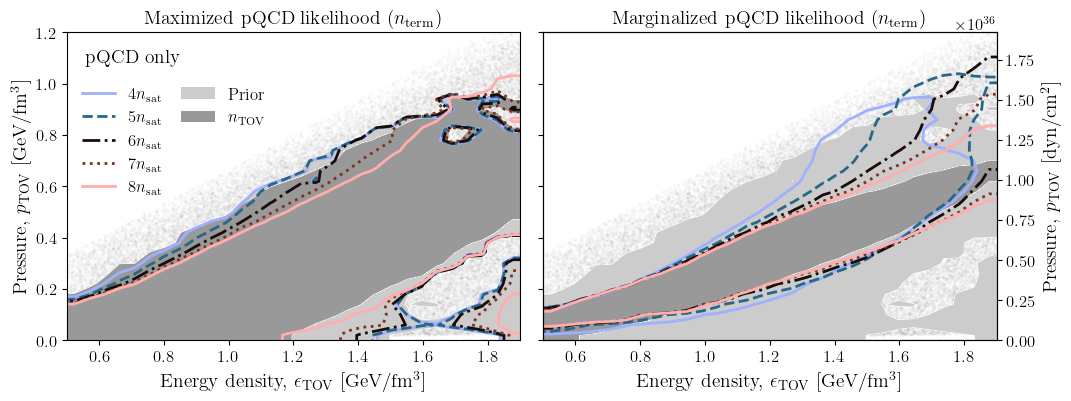

In [7]:
nterm_list = [4,5,6,7,8]
linestyles = ['-', '--', '-.', ':']
linewidth = 2
colors = [to_hex(cm.berlin(i/(len(nterm_list)-1))) for i in range(len(nterm_list))]

prior_c = 'k'
prior_alpha = 0.2

ntov_c = 'k'
ntov_alpha = 0.4

# If you want to see all the nTOV values...
# eps_lim = (0, 10)
# p_lim = (0, 5)

# Or just the main group:
# eps_lim = (0, 3)
# p_lim = (0, 1.5)

# Or just the main group:
eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

titles = [
    'Maximized pQCD likelihood ($n_\mathrm{term}$)', 
    'Marginalized pQCD likelihood ($n_\mathrm{term}$)'
]

ntov_weights = [
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'),
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat')
]

nterm_weights = []
for nterm in nterm_list:
    nterm_weights.append([
        np.loadtxt(f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_Xmarg_mu2.6.dat'),
        np.loadtxt(f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_marg.dat')
    ]) 

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)
axs[0].text(0.04, 0.9, 'pQCD only', transform=axs[0].transAxes)

for i, ax in enumerate(axs):

    ax.set_title(titles[i])

    # Prior
    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        bins=30, 
        levels=[0.9],
        range=[eps_lim, p_lim],
        smooth=0.5,
        color=prior_c,
        plot_datapoints=True,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=False,
        data_kwargs={'alpha': 0.02},
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'alpha': prior_alpha, 'antialiased': True},
    )
    
    # nTOV posterior
    weights = ntov_weights[i]
    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights, 
        bins=30, 
        levels=[0.9],
        range=[eps_lim, p_lim],
        smooth=0.5,
        color=ntov_c,
        plot_datapoints=False,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=False,
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'alpha': ntov_alpha, 'antialiased': True},
    )
    
    # nterm posteriors
    for j, weights_max_marg in enumerate(nterm_weights):

        weights = weights_max_marg[i]

        corner.hist2d(
            energy_density_at_ntov, 
            pressure_at_ntov, 
            ax=ax,
            weights=weights, 
            bins=30, 
            levels=[0.9],
            range=[eps_lim, p_lim],
            smooth=0.5,
            color=colors[j],
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={
                'linestyles': linestyles[j%len(linestyles)], 
                'linewidths': linewidth
            },
        )

# Legend
contours = [
    Line2D(
        [0], [0], 
        color=colors[i], 
        linestyle=linestyles[i%len(linestyles)], 
        linewidth=linewidth
    ) 
    for i in range(len(nterm_list))
]
contour_labels = [f'${nterm}n_\mathrm{{sat}}$' for nterm in nterm_list]

filled_contours = [
    mpatches.Patch(color=prior_c, alpha=prior_alpha, linewidth=0),
    mpatches.Patch(color=ntov_c, alpha=ntov_alpha, linewidth=0)
]
filled_contour_labels = ['Prior', '$n_\mathrm{TOV}$']

l1 = axs[0].legend(
    contours,
    contour_labels,
    loc='upper left',
    ncol=1,
    frameon=False,
    bbox_to_anchor=(0, 0.87)
)
axs[0].add_artist(l1)

l2 = axs[0].legend(
    filled_contours,
    filled_contour_labels,
    loc='upper left',
    bbox_to_anchor=(0.22, 0.87),
    frameon=False
)
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure, $p_\mathrm{TOV}$ [GeV/fm$^3$]');

# pQCD only, with mass cut

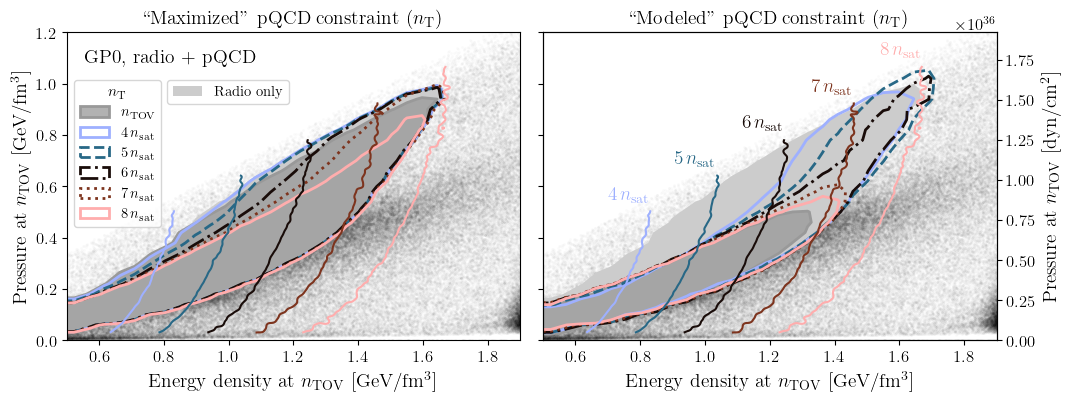

In [8]:
nterm_list = [4,5,6,7,8]
linestyles = ['-', '--', '-.', ':']
linewidth = 2
colors = [to_hex(cm.berlin(i/(len(nterm_list)-1))) for i in range(len(nterm_list))]

prior_c = 'k'
prior_alpha = 0.2

ntov_c = '#999999'

# If you want to see all the nTOV values...
# eps_lim = (0, 10)
# p_lim = (0, 5)

# Or just the main group:
# eps_lim = (0, 3)
# p_lim = (0, 1.5)

# Or just the main group:
eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

titles = [
    '``Maximized" pQCD constraint ($n_\mathrm{T}$)', 
    '``Modeled" pQCD constraint ($n_\mathrm{T}$)'
]

ntov_weights = [
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'),
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat')
]

nterm_weights = []
for nterm in nterm_list:
    nterm_weights.append([
        np.loadtxt(f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_Xmarg_mu2.6.dat'),
        np.loadtxt(f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_marg.dat')
    ]) 

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)
axs[0].text(0.04, 0.9, 'GP0, radio + pQCD', transform=axs[0].transAxes)

for i, ax in enumerate(axs):

    ax.set_title(titles[i])

    # Prior
    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=mass_weights, 
        bins=30, 
        levels=[0.9],
        range=[eps_lim, p_lim],
        smooth=0.5,
        color=prior_c,
        plot_datapoints=True,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=True,
        data_kwargs={'alpha': 0.02},
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'colors': '#cccccc', 'antialiased': True},
    )
    
    # nTOV posterior
    weights = ntov_weights[i]
    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights*mass_weights, 
        bins=30, 
        levels=[0.9],
        range=[eps_lim, p_lim],
        smooth=0.5,
        color=ntov_c,
        plot_datapoints=False,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=True,
        contour_kwargs={'linewidths': 2},
        contourf_kwargs={'colors': ntov_c, 'antialiased': True, 'alpha': 0.75},
    )
    
    # nterm posteriors
    for j, weights_max_marg in enumerate(nterm_weights):

        weights = weights_max_marg[i]

        corner.hist2d(
            energy_density_at_ntov, 
            pressure_at_ntov, 
            ax=ax,
            weights=weights*mass_weights, 
            bins=30, 
            levels=[0.9],
            range=[eps_lim, p_lim],
            smooth=0.5,
            color=colors[j],
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={
                'linestyles': linestyles[j%len(linestyles)], 
                'linewidths': linewidth
            },
        )

# Contours
plot_mask = (
    (energy_density_at_ntov > eps_lim[0]) & (energy_density_at_ntov < eps_lim[1])
)

n_grid = 1000
grid_x, grid_y = np.mgrid[eps_lim[0]:eps_lim[1]:n_grid*1j, p_lim[0]:p_lim[1]:n_grid*1j]

points = np.array([energy_density_at_ntov[plot_mask], pressure_at_ntov[plot_mask]]).T
values = collated_ntov[plot_mask]/nsat
grid = griddata(points, values, (grid_x, grid_y), method='linear')
grid = gaussian_filter(grid, 6)

for ax in axs:
    CS = ax.contour(
        grid_x, 
        grid_y, 
        grid, 
        nterm_list, 
        linestyles='-', 
        linewidths=1.5, 
        alpha=1, 
        colors=colors
    )

for i, nterm in enumerate(nterm_list):
    axs[1].text(
        CS.allsegs[i][0][-1][0], 
        CS.allsegs[i][0][-1][1]+0.025, 
        f'${nterm}\,n_\mathrm{{sat}}$', 
        color=colors[i], 
        fontsize=14, 
        horizontalalignment='right', 
        verticalalignment='bottom'
    )

# Legend
contours = [
    mpatches.Patch(
        edgecolor=colors[i], 
        facecolor= [0.6, 0.6, 0.6, 0.0],
        linestyle=linestyles[i%len(linestyles)], 
        linewidth=linewidth
    ) 
    for i in range(len(nterm_list))
]
contours = [mpatches.Patch(edgecolor=ntov_c, linewidth=2, facecolor= [0.6, 0.6, 0.6, 0.75])] + contours
contour_labels = ['$n_\mathrm{TOV}$'] + [f'${nterm}\,n_\mathrm{{sat}}$' for nterm in nterm_list]

filled_contours = [
    mpatches.Patch(color=prior_c, alpha=prior_alpha, linewidth=0),
]
filled_contour_labels = ['Radio only']

l1 = axs[0].legend(
    contours,
    contour_labels,
    loc='upper left',
    ncol=1,
    bbox_to_anchor=(0, 0.87),
    title='$n_\mathrm{T}$',
    fontsize=10.5,
    title_fontsize=11
)
axs[0].add_artist(l1)

l2 = axs[0].legend(
    filled_contours,
    filled_contour_labels,
    loc='upper left',
    bbox_to_anchor=(0.205, 0.87),
    fontsize=10.5,
)
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/paper/p_eps_tov_pqcd_radio.pdf', bbox_inches='tight')

# pQCD + astro

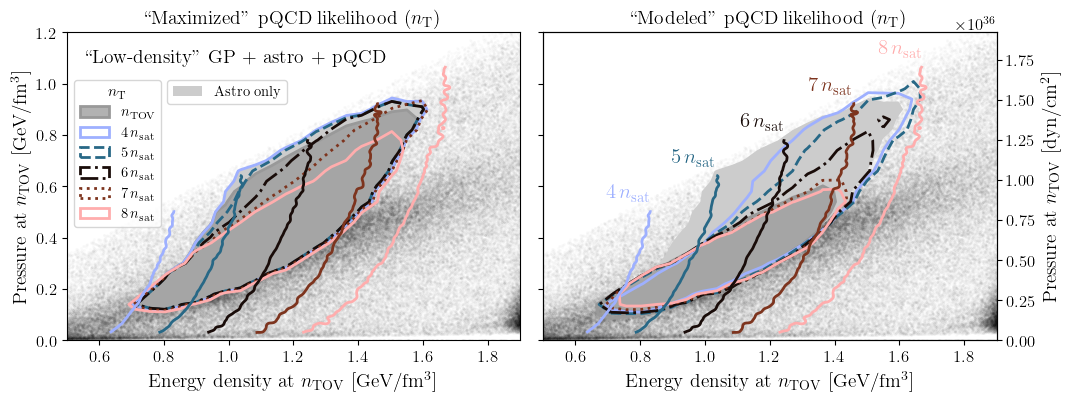

In [9]:
nterm_list = [4,5,6,7,8]
linestyles = ['-', '--', '-.', ':']
linewidth = 2
colors = [to_hex(cm.berlin(i/(len(nterm_list)-1))) for i in range(len(nterm_list))]

prior_c = 'k'
prior_alpha = 0.2

ntov_c = '#999999'

# If you want to see all the nTOV values...
# eps_lim = (0, 10)
# p_lim = (0, 5)

# Or just the main group:
# eps_lim = (0, 3)
# p_lim = (0, 1.5)

# Or just the main group:
eps_lim = (0.5, 1.9)
p_lim = (0, 1.2)

titles = [
    '``Maximized" pQCD likelihood ($n_\mathrm{T}$)', 
    '``Modeled" pQCD likelihood ($n_\mathrm{T}$)'
]

ntov_weights = [
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'),
    np.loadtxt('../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat')
]

nterm_weights = []
for nterm in nterm_list:
    nterm_weights.append([
        np.loadtxt(f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_Xmarg_mu2.6.dat'),
        np.loadtxt(f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{nterm:02}nsat_marg.dat')
    ]) 

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)
axs[0].text(0.04, 0.9, "``Low-density'' GP + astro + pQCD", transform=axs[0].transAxes)

for i, ax in enumerate(axs):

    ax.set_title(titles[i])

    # Prior
    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=astro_weights, 
        bins=30, 
        levels=[0.9],
        range=[eps_lim, p_lim],
        smooth=0.5,
        color=prior_c,
        plot_datapoints=True,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=True,
        data_kwargs={'alpha': 0.02},
        contour_kwargs={'linewidths': 0},
        contourf_kwargs={'colors': '#cccccc', 'antialiased': True},
    )
    
    # nTOV posterior
    weights = ntov_weights[i]
    corner.hist2d(
        energy_density_at_ntov, 
        pressure_at_ntov, 
        ax=ax,
        weights=weights*astro_weights, 
        bins=30, 
        levels=[0.9],
        range=[eps_lim, p_lim],
        smooth=0.5,
        color=ntov_c,
        plot_datapoints=False,
        fill_contours=True,
        plot_density=False,
        no_fill_contours=True,
        contour_kwargs={'linewidths': 2},
        contourf_kwargs={'colors': ntov_c, 'antialiased': True, 'alpha': 0.75},
    )
    
    # nterm posteriors
    for j, weights_max_marg in enumerate(nterm_weights):

        weights = weights_max_marg[i]

        corner.hist2d(
            energy_density_at_ntov, 
            pressure_at_ntov, 
            ax=ax,
            weights=weights*astro_weights, 
            bins=30, 
            levels=[0.9],
            range=[eps_lim, p_lim],
            smooth=0.5,
            color=colors[j],
            plot_datapoints=False,
            fill_contours=False,
            no_fill_contours=True,
            plot_density=False,
            contour_kwargs={
                'linestyles': linestyles[j%len(linestyles)], 
                'linewidths': linewidth
            },
        )

# Contours
plot_mask = (
    (energy_density_at_ntov > eps_lim[0]) & (energy_density_at_ntov < eps_lim[1])
)

n_grid = 1000
grid_x, grid_y = np.mgrid[eps_lim[0]:eps_lim[1]:n_grid*1j, p_lim[0]:p_lim[1]:n_grid*1j]

points = np.array([energy_density_at_ntov[plot_mask], pressure_at_ntov[plot_mask]]).T
values = collated_ntov[plot_mask]/nsat
grid = griddata(points, values, (grid_x, grid_y), method='linear')
grid = gaussian_filter(grid, 6)

for ax in axs:
    CS = ax.contour(
        grid_x, 
        grid_y, 
        grid, 
        nterm_list, 
        linestyles='-', 
        linewidths=2, 
        alpha=1, 
        colors=colors
    )

for i, nterm in enumerate(nterm_list):
    axs[1].text(
        CS.allsegs[i][0][-1][0], 
        CS.allsegs[i][0][-1][1]+0.025, 
        f'${nterm}\,n_\mathrm{{sat}}$', 
        color=colors[i], 
        fontsize=15, 
        horizontalalignment='right', 
        verticalalignment='bottom'
    )

# ---

contours = [
    mpatches.Patch(
        edgecolor=colors[i], 
        facecolor= [0.6, 0.6, 0.6, 0.0],
        linestyle=linestyles[i%len(linestyles)], 
        linewidth=linewidth
    ) 
    for i in range(len(nterm_list))
]
contours = [mpatches.Patch(edgecolor=ntov_c, linewidth=2, facecolor= [0.6, 0.6, 0.6, 0.75])] + contours
contour_labels = ['$n_\mathrm{TOV}$'] + [f'${nterm}\,n_\mathrm{{sat}}$' for nterm in nterm_list]

filled_contours = [
    mpatches.Patch(color=prior_c, alpha=prior_alpha, linewidth=0),
]
filled_contour_labels = ['Astro only']

l1 = axs[0].legend(
    contours,
    contour_labels,
    loc='upper left',
    ncol=1,
    bbox_to_anchor=(0, 0.87),
    title='$n_\mathrm{T}$',
    fontsize=10.5,
    title_fontsize=11
)
axs[0].add_artist(l1)

l2 = axs[0].legend(
    filled_contours,
    filled_contour_labels,
    loc='upper left',
    bbox_to_anchor=(0.205, 0.87),
    fontsize=10.5,
)
    
twinx = axs[1].twinx()
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [dyn/cm$^2$]')

for ax in axs:
    ax.set_xlabel(r'Energy density at $n_\mathrm{TOV}$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Pressure at $n_\mathrm{TOV}$ [GeV/fm$^3$]')

fig.savefig('figures/paper/p_eps_tov_pqcd_astro.pdf', bbox_inches='tight')

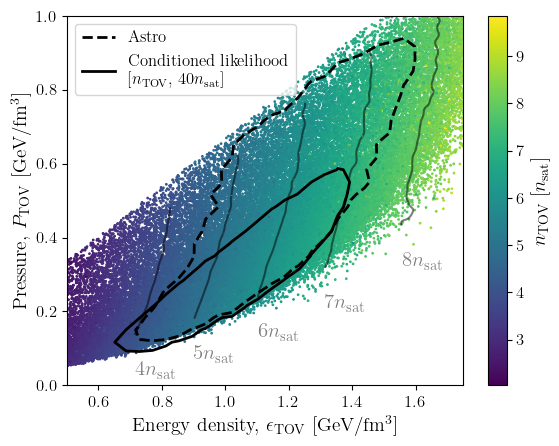

In [10]:
# Alternatve plot focussing on EOSs with non-zero astro weight
mask = collated_eos.logweight_total > -np.inf

eps_lim = (0.5, 1.75)
plot_mask = (
    (energy_density_at_ntov[mask] > eps_lim[0]) & 
    (energy_density_at_ntov[mask] < eps_lim[1])
)

p_lim = (0, 1)

fig, ax = plt.subplots()

im = ax.scatter(
    energy_density_at_ntov[mask][plot_mask], 
    pressure_at_ntov[mask][plot_mask], 
    c=collated_ntov[mask][plot_mask]/nsat, 
    cmap='viridis',
    s=1
    )
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

n_grid = 500
grid_x, grid_y = np.mgrid[eps_lim[0]:eps_lim[1]:n_grid*1j, p_lim[0]:p_lim[1]:n_grid*1j]

points = np.array([
    energy_density_at_ntov[mask][plot_mask], pressure_at_ntov[mask][plot_mask]
]).T
values = collated_ntov[mask][plot_mask]/nsat
grid = griddata(points, values, (grid_x, grid_y), method='linear')
grid = gaussian_filter(grid, 5)

contour_levels = [4,5,6,7,8]

CS = ax.contour(
    grid_x, 
    grid_y, 
    grid, 
    contour_levels, 
    colors='k', 
    linestyles='-', 
    linewidths=1.5, 
    alpha=0.5
    )

for i, ntov in enumerate(contour_levels):
    ax.text(
        CS.allsegs[i][0][0][0], 
        CS.allsegs[i][0][0][1]-0.075, 
        f'${ntov}n_\mathrm{{sat}}$', 
        color='k', 
        alpha=0.5,
        fontsize=15, 
        horizontalalignment='left', 
        verticalalignment='top'
        )

corner.hist2d(
    energy_density_at_ntov[mask], 
    pressure_at_ntov[mask], 
    ax=ax,
    weights=astro_weights[mask], 
    bins=30, 
    levels=[0.9],
    range=[eps_lim, p_lim],
    smooth=0.5,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=False,
    no_fill_contours=True,
    contour_kwargs={'linestyles': '--', 'linewidths': 2},
    )

nterm_weights = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat'
)

corner.hist2d(
    energy_density_at_ntov[mask], 
    pressure_at_ntov[mask], 
    ax=ax,
    weights=(astro_weights*nterm_weights)[mask], 
    bins=30, 
    levels=[0.9],
    range=[eps_lim, p_lim],
    smooth=0.5,
    color='k',
    plot_datapoints=False,
    fill_contours=False,
    plot_density=False,
    no_fill_contours=True,
    contour_kwargs={'linestyles': '-', 'linewidths': 2},
    )

handles = [
    Line2D([0], [0], color='k', linestyle='--', linewidth=2),
    Line2D([0], [0], color='k', linestyle='-', linewidth=2),
    ]

ax.legend(
    handles,
    ['Astro', 'Conditioned likelihood \n[$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]'],
    loc='upper left',
)         

ax.set_xlabel(r'Energy density, $\epsilon_\mathrm{TOV}$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $P_\mathrm{TOV}$ [GeV/fm$^3$]')

ax.set_xlim(eps_lim)
ax.set_ylim(p_lim);